In [1]:
!pip install tensorflow

In [21]:
import zipfile
import os
import shutil
import random
import gdown
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from torchvision import models, transforms
import torch
import cv2
from PIL import Image, ImageOps
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)

In [4]:
file_id = "1FKZ9oHZ3zFMoFJX2f2aI34M2XZ2ikSb0"
gdown.download(
    f"https://drive.google.com/uc?id={file_id}",
    os.path.join(os.getcwd(), "dataset_32_classes.zip"),
    quiet=False,
)
zip_name = "dataset_32_classes.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1FKZ9oHZ3zFMoFJX2f2aI34M2XZ2ikSb0
From (redirected): https://drive.google.com/uc?id=1FKZ9oHZ3zFMoFJX2f2aI34M2XZ2ikSb0&confirm=t&uuid=695eb786-1d3a-49a3-b0ad-33331af1edcc
To: /content/dataset_32_classes.zip
100%|██████████| 641M/641M [00:13<00:00, 49.3MB/s]


In [5]:
# Распаковка архива
with zipfile.ZipFile(zip_name, "r") as zip_ref:
    zip_ref.extractall("./dataset")

In [6]:
DATASET_DIR = "./dataset"
TEMP_DIR = "./temp"

In [7]:
def set_image_size(img_path, save_path, size, color_background="white"):
    img = Image.open(img_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    ratio = img.width / img.height
    # Широкое изображение
    if ratio > 1:
        new_width = size[0]
        new_height = int(size[0] / ratio)
    # Высокое изображение
    else:
        new_height = size[1]
        new_width = int(size[1] * ratio)
    img_resized = img.resize((new_width, new_height), Image.LANCZOS)
    img_padded = ImageOps.pad(img_resized, size, color=color_background, centering=(0.5, 0.5))
    img_padded.save(save_path)

In [8]:
def creat_temp_dataset(num_temp=None, use_sample=True):
    if os.path.exists(TEMP_DIR):
        shutil.rmtree(TEMP_DIR)
    os.mkdir(TEMP_DIR)

    for class_name in tqdm(os.listdir(DATASET_DIR)):
        temp_class_path = os.path.join(TEMP_DIR, class_name)
        if os.path.exists(temp_class_path) != True:
            os.mkdir(temp_class_path)
        basedir_class_path = os.path.join(DATASET_DIR, class_name)
        image_names = os.listdir(basedir_class_path)
        if use_sample and num_temp is not None:
            # Если нужно использовать sample, и указано количество
            reduce_image_names = random.sample(image_names, min(num_temp, len(image_names)))
        else:
            # Копируем все изображения
            reduce_image_names = image_names

        for image in reduce_image_names:
            shutil.copy(os.path.join(basedir_class_path, image), os.path.join(temp_class_path, image))

In [9]:
def resize_temp_dataset(size, color_background):
    # Проверка, существует ли временный датасет
    if not os.path.exists(TEMP_DIR):
        print("Временный датасет TEMP_DIR не найден.")
        return

    # Проходим по всем классам (папкам) в TEMP_DIR
    for class_name in tqdm(os.listdir(TEMP_DIR)):
        class_path = os.path.join(TEMP_DIR, class_name)

        # Проверяем, является ли это папкой
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)

                # Проверяем, является ли это изображением
                if image_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    save_path = image_path  # Сохраняем под тем же именем
                    set_image_size(image_path, save_path, size, color_background)

In [10]:
# Функция для преобразования изображений перед передачей в модель ResNet18
def get_transform(size=(224, 224)):
    return transforms.Compose(
        [
            transforms.ToPILImage(),  # Преобразование в PIL Image
            transforms.Resize(size),  # Изменение размера
            transforms.ToTensor(),  # Преобразование в тензор
            transforms.Normalize(  # Нормализация в диапазон модели
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )

In [11]:
# Функция для получения признаков и меток классов из изображений
def get_X_and_y(size=(224, 224), color="color"):
    X = []
    y = []
    for class_name in os.listdir(TEMP_DIR):
        path_class = os.path.join(TEMP_DIR, class_name)

        for img in os.listdir(path_class):
            img_path = os.path.join(path_class, img)

            # Загружаем изображение
            if color == "grey":
                img = load_img(img_path, color_mode="grayscale")  # Загрузка в градациях серого
                img = img_to_array(img)
                img = np.repeat(img, 3, axis=-1)
            else:
                img = load_img(img_path)  # Загрузка цветного изображения
                img = img_to_array(img)

            # Добавляем размерность для модели
            transform = get_transform(size)
            img = transform(img)  # Применяем трансформации
            img = img.unsqueeze(0)  # Добавляем размерность батча
            with torch.no_grad():
                features = resn18(img)  # Извлекаем признаки
                X.append(features.squeeze().numpy())  # Плоский массив

            y.append(class_name)

    return np.array(X), np.array(y)

In [12]:
# Загрузка модели ResNet18
resn18 = models.resnet18(pretrained=True)
resn18 = torch.nn.Sequential(*(list(resn18.children())[:-1]))  # Удаление последнего слоя (выходного классификатора)
for param in resn18.parameters():
    param.requires_grad = False
resn18.eval()  # Установка модели в режим оценки (eval), нам нужно использовать resnet18 только для извлечения признаков, модель будет обучаться с помощью SVC и LogisticRegression

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

# Обучение модели на выборочном датасете из фотографий размером 224x224 px

Создаем выборочный датасет из 500 изображений в каждом классе

In [13]:
creat_temp_dataset(num_temp=500, use_sample=True)

  0%|          | 0/32 [00:00<?, ?it/s]

Приводим все изображения в выборочном датасете к размеру 224x224 px (рекомендованный размер фотографий для использования ResNet18)

In [14]:
resize_temp_dataset((224, 224), color_background="white")

  0%|          | 0/32 [00:00<?, ?it/s]

In [15]:
X, y = get_X_and_y(color="color")

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Делаем подбор гиперпараметров с помощью GridSearchCV

In [ ]:
param_grid = {
    "C": [1, 5, 10, 50],
    "kernel": ["rbf", "linear", "poly", "sigmoid"],
    "gamma": ["scale"],
}
svс = GridSearchCV(SVC(), param_grid)
svс.fit(X_train, y_train)
y_pred = svс.predict(X_test)

In [ ]:
svс.best_params_, svс.best_score_

({'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}, 0.961328125)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.88      0.89      0.89        94
     Avocado       0.96      0.86      0.91       103
      Banana       0.88      0.96      0.91        90
        Bean       0.97      1.00      0.99       110
Bitter_Gourd       1.00      1.00      1.00       124
Bottle_Gourd       1.00      0.99      1.00       108
     Brinjal       0.99      0.99      0.99       103
    Broccoli       0.99      0.99      0.99       100
     Cabbage       0.99      1.00      0.99        83
    Capsicum       0.98      0.99      0.98        97
      Carrot       1.00      1.00      1.00        98
 Cauliflower       0.99      0.99      0.99        93
      Cherry       0.96      0.91      0.94       117
    Cucumber       1.00      0.99      0.99        97
       Grape       0.99      1.00      1.00       111
        Kiwi       0.90      0.95      0.92        94
       Mango       0.87      0.89      0.88        87
         Nut       1.00    

Попытаемся получше подобрать параметр C, тем самым улучшив метрики

In [ ]:
param_grid = {"C": [40, 45, 50, 60], "kernel": ["rbf"], "gamma": ["scale"]}
svс = GridSearchCV(SVC(), param_grid, cv=2)
svс.fit(X_train, y_train)
y_pred = svс.predict(X_test)

In [ ]:
svс.best_params_, svс.best_score_

({'C': 40, 'gamma': 'scale', 'kernel': 'rbf'}, 0.9451562499999999)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.88      0.89      0.89        94
     Avocado       0.96      0.86      0.91       103
      Banana       0.88      0.96      0.91        90
        Bean       0.97      1.00      0.99       110
Bitter_Gourd       1.00      1.00      1.00       124
Bottle_Gourd       1.00      0.99      1.00       108
     Brinjal       0.99      0.99      0.99       103
    Broccoli       0.99      0.99      0.99       100
     Cabbage       0.99      1.00      0.99        83
    Capsicum       0.98      0.99      0.98        97
      Carrot       1.00      1.00      1.00        98
 Cauliflower       0.99      0.99      0.99        93
      Cherry       0.96      0.91      0.94       117
    Cucumber       1.00      0.99      0.99        97
       Grape       0.99      1.00      1.00       111
        Kiwi       0.90      0.95      0.92        94
       Mango       0.87      0.89      0.88        87
         Nut       1.00    

In [ ]:
y_name = os.listdir(DATASET_DIR)

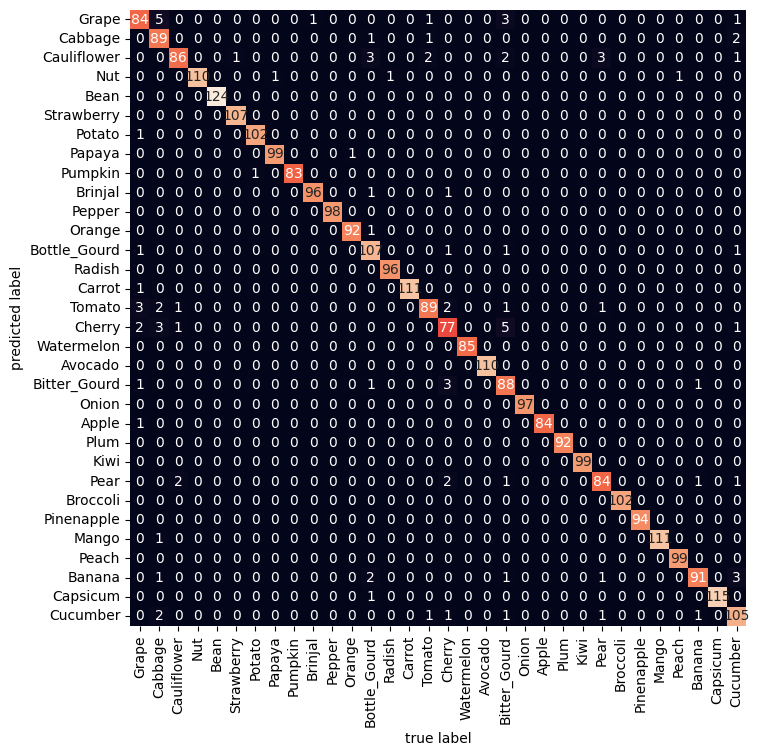

In [ ]:
plt.figure(figsize=(8, 8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=y_name, yticklabels=y_name)
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

In [ ]:
param_grid = {"C": np.arange(12, 42, 2), "kernel": ["rbf"], "gamma": ["scale"]}
svс = GridSearchCV(SVC(), param_grid)
svс.fit(X_train, y_train)
y_pred = svс.predict(X_test)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
svс.best_params_, svс.best_score_

({'C': 12, 'gamma': 'scale', 'kernel': 'rbf'}, 0.961328125)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.88      0.89      0.89        94
     Avocado       0.96      0.86      0.91       103
      Banana       0.88      0.96      0.91        90
        Bean       0.97      1.00      0.99       110
Bitter_Gourd       1.00      1.00      1.00       124
Bottle_Gourd       1.00      0.99      1.00       108
     Brinjal       0.99      0.99      0.99       103
    Broccoli       0.99      0.99      0.99       100
     Cabbage       0.99      1.00      0.99        83
    Capsicum       0.98      0.99      0.98        97
      Carrot       1.00      1.00      1.00        98
 Cauliflower       0.99      0.99      0.99        93
      Cherry       0.96      0.91      0.94       117
    Cucumber       1.00      0.99      0.99        97
       Grape       0.99      1.00      1.00       111
        Kiwi       0.90      0.95      0.92        94
       Mango       0.87      0.89      0.88        87
         Nut       1.00    

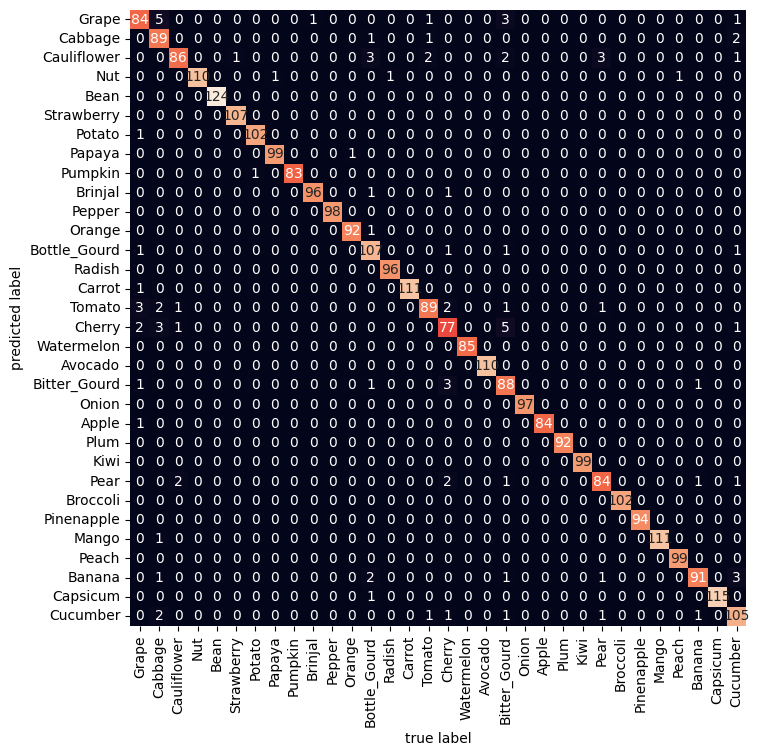

In [ ]:
plt.figure(figsize=(8, 8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=y_name, yticklabels=y_name)
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

Проверим как модель обучается с помощью логистической регрессии

In [22]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Масштабируем данные
        ("logreg", LogisticRegression(max_iter=200)),  # Увеличиваем max_iter
    ]
)

In [25]:
param_grid = {"logreg__C": [0.01, 0.1, 1, 10]}
logreg = GridSearchCV(pipeline, param_grid)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [26]:
logreg.best_params_, logreg.best_score_

({'logreg__C': 0.1}, 0.9353906249999999)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.75      0.74      0.75        90
     Avocado       0.80      0.84      0.82       110
      Banana       0.91      0.94      0.92       124
        Bean       0.94      0.99      0.96        90
Bitter_Gourd       1.00      1.00      1.00       111
Bottle_Gourd       0.97      0.98      0.98       110
     Brinjal       0.97      0.97      0.97       115
    Broccoli       0.98      0.99      0.98        92
     Cabbage       0.98      0.98      0.98        84
    Capsicum       0.99      1.00      1.00       103
      Carrot       0.99      1.00      0.99        99
 Cauliflower       0.95      0.97      0.96        87
      Cherry       0.79      0.86      0.83        94
    Cucumber       0.99      0.92      0.95       103
       Grape       0.98      0.99      0.99       115
        Kiwi       0.91      0.89      0.90        97
       Mango       0.92      0.74      0.82       117
         Nut       1.00    

SVC:модель показала лучшие данные на цветных фотографиях (accuracy на трейне = 0.96, accuracy на тесте = 0.97) при С = 12, kernel = "rbf".
LogisticRegression: при с = 0.1 accuracy на трейне = 0.94, accuracy на тесте = 0.94

Обучим модель на черно-белых фотографиях и посмотрим значения метрик

In [ ]:
X_grey, y_grey = get_X_and_y("grey")

In [ ]:
X_grey_train, X_grey_test, y_grey_train, y_grey_test = train_test_split(X_grey, y_grey, test_size=0.2, random_state=42)

In [ ]:
param_grid = {"C": [5, 7, 10, 12, 14], "kernel": ["rbf"], "gamma": ["scale"]}
svс_grey = GridSearchCV(SVC(), param_grid)
svс_grey.fit(X_train, y_train)
y_grey_pred = svс_grey.predict(X_grey_test)

In [ ]:
svс_grey.best_params_, svс_grey.best_score_

({'C': 12, 'gamma': 'scale', 'kernel': 'rbf'}, 0.961328125)

In [ ]:
print(classification_report(y_grey_test, y_grey_pred))

              precision    recall  f1-score   support

       Apple       0.39      0.64      0.49        94
     Avocado       0.42      0.86      0.57       103
      Banana       0.70      0.83      0.76        90
        Bean       0.92      0.92      0.92       110
Bitter_Gourd       1.00      0.12      0.22       124
Bottle_Gourd       0.97      0.77      0.86       108
     Brinjal       0.72      0.93      0.81       103
    Broccoli       1.00      0.93      0.96       100
     Cabbage       1.00      0.83      0.91        83
    Capsicum       1.00      0.11      0.20        97
      Carrot       0.86      0.63      0.73        98
 Cauliflower       0.93      0.98      0.95        93
      Cherry       0.67      0.51      0.58       117
    Cucumber       0.85      0.63      0.72        97
       Grape       0.77      0.97      0.86       111
        Kiwi       0.47      0.82      0.60        94
       Mango       0.60      0.53      0.56        87
         Nut       0.81    

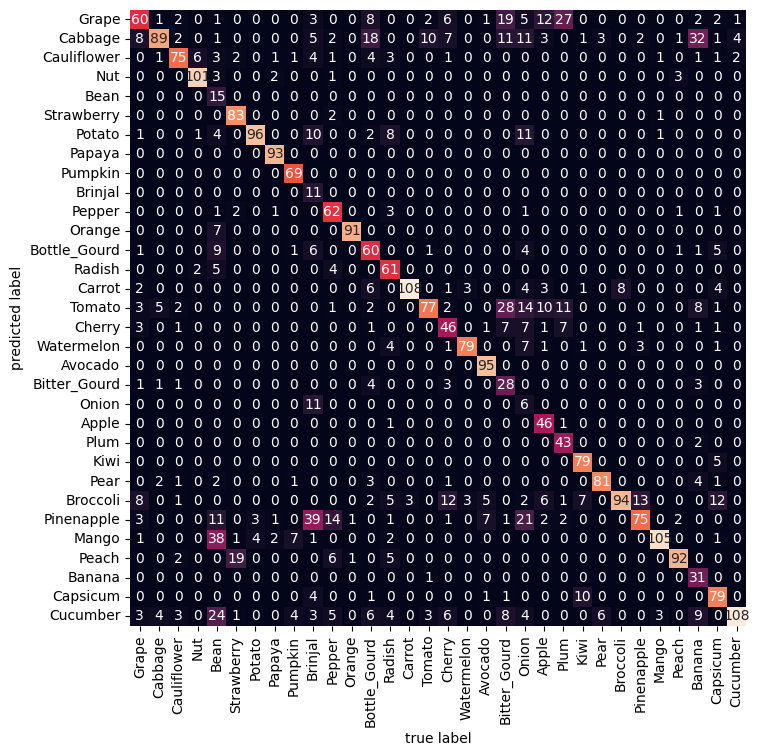

In [ ]:
plt.figure(figsize=(8, 8))
mat = confusion_matrix(y_grey_test, y_grey_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=y_name, yticklabels=y_name)
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

При с = 12, kernel = 'rbf' accuracy на трейне = 0.96, accuracy на тесте = 0.7, что может говорить о переобучении. Так как значения метрик сильно лучше на цветных фотографиях, то дальнейшее обучение будет проходить на датасете цветных фотографий

# Обучение модели на выборочном датасете из фотографий размером 64x64 px

In [28]:
creat_temp_dataset(num_temp=500, use_sample=True)

  0%|          | 0/32 [00:00<?, ?it/s]

In [29]:
resize_temp_dataset((64, 64), color_background="white")

  0%|          | 0/32 [00:00<?, ?it/s]

In [30]:
X, y = get_X_and_y(size=(64, 64), color="color")

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
param_grid = {"C": [8, 10, 12, 14], "kernel": ["rbf"], "gamma": ["scale"]}
svс = GridSearchCV(SVC(), param_grid)
svс.fit(X_train, y_train)
y_pred = svс.predict(X_test)

In [ ]:
svс.best_params_, svс.best_score_

({'C': 14, 'gamma': 'scale', 'kernel': 'rbf'}, 0.8943749999999999)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.70      0.66      0.68        94
     Avocado       0.82      0.77      0.79       103
      Banana       0.70      0.84      0.76        90
        Bean       0.96      0.97      0.96       110
Bitter_Gourd       0.98      0.95      0.97       124
Bottle_Gourd       0.95      1.00      0.97       108
     Brinjal       0.90      0.94      0.92       103
    Broccoli       0.94      0.95      0.95       100
     Cabbage       0.92      0.95      0.93        83
    Capsicum       0.90      0.98      0.94        97
      Carrot       0.99      1.00      0.99        98
 Cauliflower       0.96      0.98      0.97        93
      Cherry       0.73      0.79      0.76       117
    Cucumber       0.98      0.93      0.95        97
       Grape       1.00      1.00      1.00       111
        Kiwi       0.77      0.68      0.72        94
       Mango       0.78      0.82      0.80        87
         Nut       0.97    

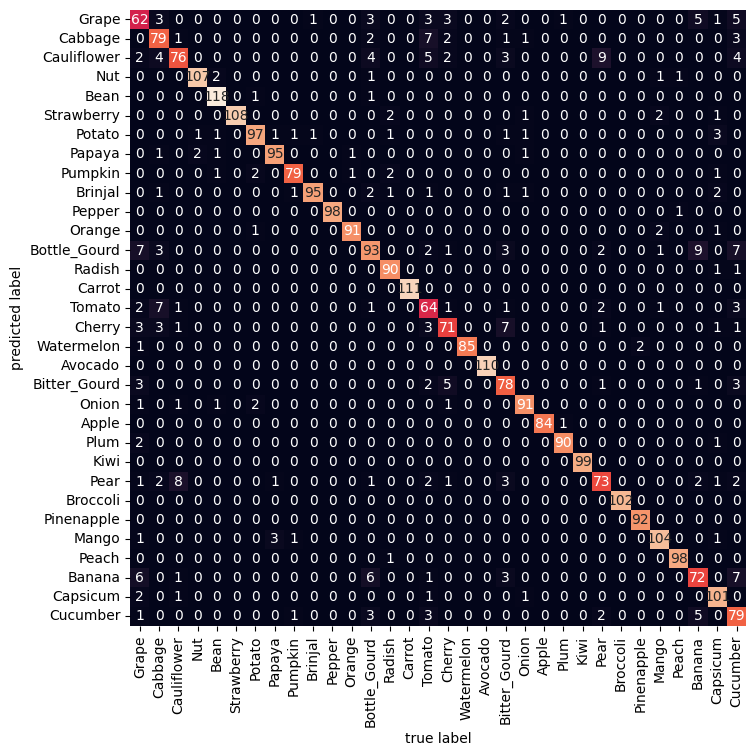

In [ ]:
plt.figure(figsize=(8, 8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=y_name, yticklabels=y_name)
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

In [ ]:
param_grid = {"C": np.arange(10, 20, 2), "kernel": ["rbf"], "gamma": ["scale"]}
svс = GridSearchCV(SVC(), param_grid)
svс.fit(X_train, y_train)
y_pred = svс.predict(X_test)

In [ ]:
svс.best_params_, svс.best_score_

({'C': 18, 'gamma': 'scale', 'kernel': 'rbf'}, 0.8946093749999999)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.70      0.67      0.68        94
     Avocado       0.82      0.77      0.79       103
      Banana       0.70      0.84      0.76        90
        Bean       0.96      0.97      0.96       110
Bitter_Gourd       0.98      0.95      0.97       124
Bottle_Gourd       0.95      1.00      0.97       108
     Brinjal       0.90      0.94      0.92       103
    Broccoli       0.94      0.95      0.95       100
     Cabbage       0.91      0.95      0.93        83
    Capsicum       0.90      0.98      0.94        97
      Carrot       0.99      1.00      0.99        98
 Cauliflower       0.96      0.98      0.97        93
      Cherry       0.73      0.79      0.76       117
    Cucumber       0.98      0.93      0.95        97
       Grape       1.00      1.00      1.00       111
        Kiwi       0.78      0.68      0.73        94
       Mango       0.77      0.79      0.78        87
         Nut       0.97    

Проверим как модель обучается с помощью логистической регрессии на фотографиях размера 64x64

In [33]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Масштабируем данные
        ("logreg", LogisticRegression(max_iter=200)),  # Увеличиваем max_iter
    ]
)

In [34]:
param_grid = {"logreg__C": [0.01, 0.1, 1, 10]}
logreg = GridSearchCV(pipeline, param_grid)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [35]:
logreg.best_params_, logreg.best_score_

({'logreg__C': 0.1}, 0.848046875)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.64      0.57      0.60        90
     Avocado       0.69      0.71      0.70       110
      Banana       0.84      0.74      0.79       124
        Bean       0.91      0.90      0.91        90
Bitter_Gourd       0.91      0.94      0.92       111
Bottle_Gourd       0.95      0.95      0.95       110
     Brinjal       0.87      0.86      0.86       115
    Broccoli       0.96      0.95      0.95        92
     Cabbage       0.93      0.89      0.91        84
    Capsicum       0.88      0.94      0.91       103
      Carrot       0.97      0.96      0.96        99
 Cauliflower       0.97      0.97      0.97        87
      Cherry       0.67      0.78      0.72        94
    Cucumber       0.88      0.86      0.87       103
       Grape       0.99      1.00      1.00       115
        Kiwi       0.68      0.76      0.72        97
       Mango       0.67      0.61      0.64       117
         Nut       0.97    

SVC: accuracy на трейне = 0.89, accuracy на тесте = 0.90 при С = 18, kernel = "rbf".
LogisticRegression: при с = 0.1 accuracy на трейне = 0.85, accuracy на тесте = 0.86

# Обучение модели на выборочном датасете из фотографий размером 128x128 px

In [37]:
creat_temp_dataset(num_temp=500, use_sample=True)

  0%|          | 0/32 [00:00<?, ?it/s]

In [38]:
resize_temp_dataset((128, 128), color_background="white")

  0%|          | 0/32 [00:00<?, ?it/s]

In [39]:
X, y = get_X_and_y(size=(128, 128), color="color")

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
param_grid = {"C": [4, 8, 10, 12, 16], "kernel": ["rbf"], "gamma": ["scale"]}
svс = GridSearchCV(SVC(), param_grid)
svс.fit(X_train, y_train)
y_pred = svс.predict(X_test)

In [ ]:
svс.best_params_, svс.best_score_

({'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}, 0.9364062499999999)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.86      0.83      0.84        94
     Avocado       0.86      0.86      0.86       103
      Banana       0.86      0.86      0.86        90
        Bean       0.97      1.00      0.99       110
Bitter_Gourd       0.99      1.00      1.00       124
Bottle_Gourd       0.99      0.99      0.99       108
     Brinjal       0.97      0.97      0.97       103
    Broccoli       1.00      0.98      0.99       100
     Cabbage       1.00      1.00      1.00        83
    Capsicum       0.94      0.97      0.95        97
      Carrot       1.00      0.99      0.99        98
 Cauliflower       1.00      1.00      1.00        93
      Cherry       0.90      0.81      0.85       117
    Cucumber       0.97      0.95      0.96        97
       Grape       1.00      1.00      1.00       111
        Kiwi       0.87      0.86      0.87        94
       Mango       0.78      0.79      0.78        87
         Nut       1.00    

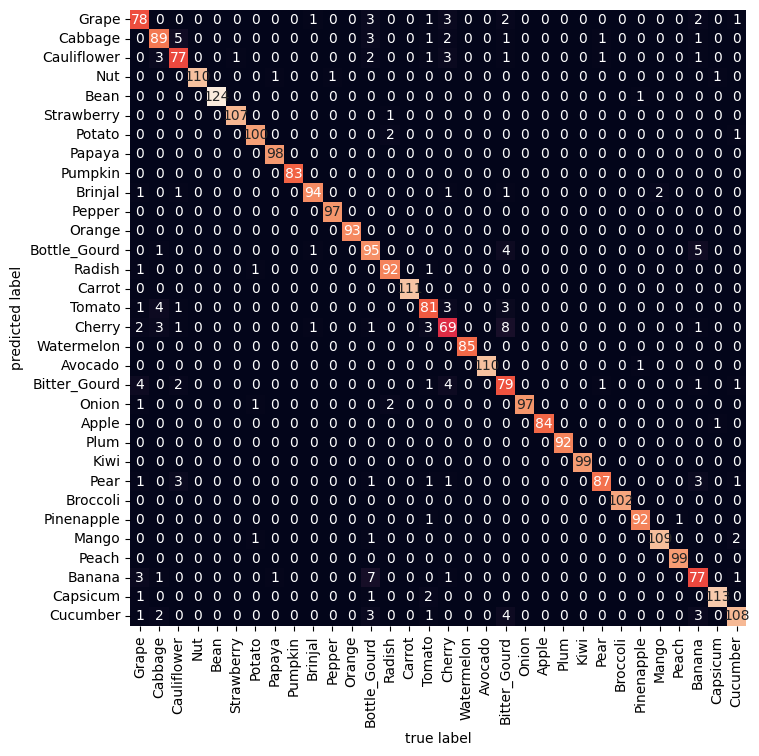

In [ ]:
plt.figure(figsize=(8, 8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=y_name, yticklabels=y_name)
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

Проверим как модель обучается с помощью логистической регрессии на фотографиях размера 128x128

In [41]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Масштабируем данные
        ("logreg", LogisticRegression(max_iter=200)),  # Увеличиваем max_iter
    ]
)

In [42]:
param_grid = {"logreg__C": [0.01, 0.1, 1, 10]}
logreg = GridSearchCV(pipeline, param_grid)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [43]:
logreg.best_params_, logreg.best_score_

({'logreg__C': 0.1}, 0.899453125)

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.69      0.70      0.70        90
     Avocado       0.76      0.81      0.78       110
      Banana       0.82      0.75      0.78       124
        Bean       0.94      0.97      0.95        90
Bitter_Gourd       0.99      0.97      0.98       111
Bottle_Gourd       0.96      0.96      0.96       110
     Brinjal       1.00      0.90      0.95       115
    Broccoli       0.99      1.00      0.99        92
     Cabbage       0.99      1.00      0.99        84
    Capsicum       0.93      0.94      0.94       103
      Carrot       0.98      0.97      0.97        99
 Cauliflower       0.98      0.99      0.98        87
      Cherry       0.69      0.77      0.73        94
    Cucumber       0.92      0.95      0.93       103
       Grape       1.00      1.00      1.00       115
        Kiwi       0.82      0.73      0.77        97
       Mango       0.84      0.79      0.81       117
         Nut       0.99    

SVC: accuracy на трейне = 0.94, accuracy на тесте = 0.95 при С = 10, kernel = "rbf".
LogisticRegression: при с = 0.1 accuracy на трейне = 0.90, accuracy на тесте = 0.91

# Обучение модели на полном датасете цветных фотографий размера 224x224 px

In [72]:
creat_temp_dataset(use_sample=False)

  0%|          | 0/32 [00:00<?, ?it/s]

In [73]:
resize_temp_dataset((224, 224), color_background="white")

  0%|          | 0/32 [00:00<?, ?it/s]

In [74]:
X, y = get_X_and_y(color="color")

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
svс = SVC(C=12, kernel="rbf")
svс.fit(X_train, y_train)
y_pred = svс.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.95      0.93      0.94       290
     Avocado       0.93      0.94      0.94       286
      Banana       0.90      0.95      0.92       253
        Bean       1.00      1.00      1.00       271
Bitter_Gourd       1.00      1.00      1.00       259
Bottle_Gourd       1.00      1.00      1.00       259
     Brinjal       0.99      0.99      0.99       303
    Broccoli       1.00      0.99      1.00       294
     Cabbage       0.99      1.00      1.00       296
    Capsicum       0.99      1.00      0.99       273
      Carrot       1.00      1.00      1.00       286
 Cauliflower       1.00      0.99      0.99       299
      Cherry       0.94      0.94      0.94       273
    Cucumber       1.00      1.00      1.00       271
       Grape       1.00      1.00      1.00       273
        Kiwi       0.96      0.94      0.95       252
       Mango       0.90      0.91      0.90       296
         Nut       1.00    

In [ ]:
y_pred_tr = svс.predict(X_train)

In [ ]:
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00      1110
     Avocado       1.00      1.00      1.00      1114
      Banana       1.00      1.00      1.00      1147
        Bean       1.00      1.00      1.00      1129
Bitter_Gourd       1.00      1.00      1.00      1141
Bottle_Gourd       1.00      1.00      1.00      1141
     Brinjal       1.00      1.00      1.00      1097
    Broccoli       1.00      1.00      1.00      1106
     Cabbage       1.00      1.00      1.00      1104
    Capsicum       1.00      1.00      1.00      1127
      Carrot       1.00      1.00      1.00      1114
 Cauliflower       1.00      1.00      1.00      1101
      Cherry       1.00      1.00      1.00      1127
    Cucumber       1.00      1.00      1.00      1129
       Grape       1.00      1.00      1.00      1127
        Kiwi       1.00      1.00      1.00      1148
       Mango       1.00      1.00      1.00      1104
         Nut       1.00    

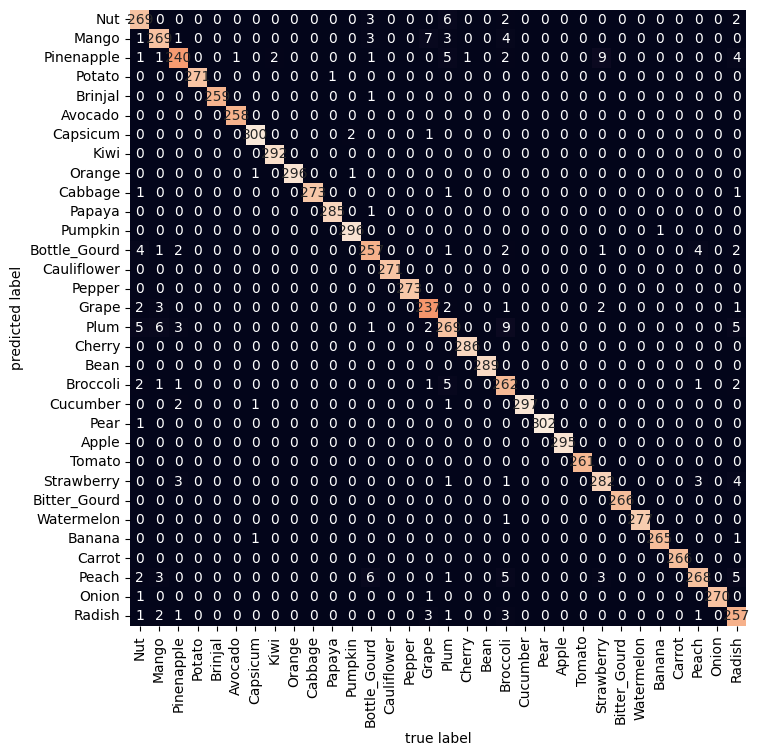

In [ ]:
plt.figure(figsize=(8, 8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=y_name, yticklabels=y_name)
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

**LogisticRegression**

In [76]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Масштабируем данные
        ("logreg", LogisticRegression(C=0.1, max_iter=200)),  # Увеличиваем max_iter
    ]
)

In [77]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [78]:
y_pred_tr = pipeline.predict(X_train)
accuracy_score(y_train, y_pred_tr)

0.9899274553571429

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.86      0.82      0.84       284
     Avocado       0.90      0.90      0.90       271
      Banana       0.94      0.90      0.92       294
        Bean       0.99      1.00      0.99       302
Bitter_Gourd       1.00      1.00      1.00       292
Bottle_Gourd       1.00      1.00      1.00       303
     Brinjal       0.98      0.99      0.98       273
    Broccoli       0.99      0.99      0.99       277
     Cabbage       0.99      0.99      0.99       286
    Capsicum       0.96      0.99      0.97       271
      Carrot       1.00      1.00      1.00       297
 Cauliflower       1.00      0.99      0.99       253
      Cherry       0.86      0.86      0.86       273
    Cucumber       0.99      0.98      0.99       266
       Grape       1.00      1.00      1.00       273
        Kiwi       0.91      0.93      0.92       252
       Mango       0.83      0.83      0.83       266
         Nut       1.00    

SVC: accuracy на трейне = 1.0, accuracy на тесте = 0.98 при С = 12, kernel = "rbf".
LogisticRegression: при с = 0.1 accuracy на трейне = 0.99, accuracy на тесте = 0.96

# Обучение модели на полном датасете цветных фотографий размером 128x128 px

In [55]:
creat_temp_dataset(use_sample=False)

  0%|          | 0/32 [00:00<?, ?it/s]

In [56]:
resize_temp_dataset((128, 128), color_background="white")

  0%|          | 0/32 [00:00<?, ?it/s]

In [57]:
X, y = get_X_and_y(size=(128, 128), color="color")

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
svс = SVC(C=10, kernel="rbf")
svс.fit(X_train, y_train)
y_pred = svс.predict(X_test)

In [ ]:
y_pred_tr = svс.predict(X_train)

In [ ]:
accuracy_score(y_train, y_pred_tr)

0.9996651785714286

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.89      0.91      0.90       290
     Avocado       0.89      0.91      0.90       286
      Banana       0.87      0.92      0.89       253
        Bean       0.99      1.00      0.99       271
Bitter_Gourd       1.00      1.00      1.00       259
Bottle_Gourd       1.00      1.00      1.00       259
     Brinjal       0.97      0.98      0.98       303
    Broccoli       1.00      0.99      0.99       294
     Cabbage       0.99      1.00      0.99       296
    Capsicum       0.97      1.00      0.98       273
      Carrot       0.99      0.99      0.99       286
 Cauliflower       0.99      0.99      0.99       299
      Cherry       0.87      0.92      0.89       273
    Cucumber       1.00      1.00      1.00       271
       Grape       1.00      1.00      1.00       273
        Kiwi       0.93      0.90      0.92       252
       Mango       0.89      0.83      0.86       296
         Nut       1.00    

**LogisticRegression**

In [59]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Масштабируем данные
        ("logreg", LogisticRegression(C=0.1, max_iter=200)),  # Увеличиваем max_iter
    ]
)

In [60]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [61]:
y_pred_tr = pipeline.predict(X_train)
accuracy_score(y_train, y_pred_tr)

0.9740513392857143

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.82      0.77      0.79       284
     Avocado       0.80      0.81      0.81       271
      Banana       0.84      0.84      0.84       294
        Bean       0.98      0.99      0.98       302
Bitter_Gourd       0.99      0.99      0.99       292
Bottle_Gourd       0.97      0.98      0.98       303
     Brinjal       0.96      0.96      0.96       273
    Broccoli       0.98      0.99      0.98       277
     Cabbage       0.99      0.97      0.98       286
    Capsicum       0.96      0.98      0.97       271
      Carrot       0.99      0.99      0.99       297
 Cauliflower       0.99      0.99      0.99       253
      Cherry       0.83      0.80      0.81       273
    Cucumber       0.97      0.95      0.96       266
       Grape       0.99      1.00      0.99       273
        Kiwi       0.84      0.87      0.85       252
       Mango       0.77      0.74      0.76       266
         Nut       1.00    

SVC: accuracy на трейне = 1.0, accuracy на тесте = 0.96 при С = 10, kernel = "rbf".
LogisticRegression: при с = 0.1 accuracy на трейне = 0.97, accuracy на тесте = 0.93

# Обучение модели на полном датасете цветных фотографий размером 64x64 px

In [63]:
creat_temp_dataset(use_sample=False)

  0%|          | 0/32 [00:00<?, ?it/s]

In [64]:
resize_temp_dataset((64, 64), color_background="white")

  0%|          | 0/32 [00:00<?, ?it/s]

In [65]:
X, y = get_X_and_y(size=(64, 64), color="color")

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
svс = SVC(C=18, kernel="rbf")
svс.fit(X_train, y_train)
y_pred = svс.predict(X_test)

In [ ]:
y_pred_tr = svс.predict(X_train)
accuracy_score(y_train, y_pred_tr)

0.9974609375

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.86      0.83      0.84       284
     Avocado       0.81      0.84      0.82       271
      Banana       0.85      0.89      0.87       294
        Bean       0.97      0.99      0.98       302
Bitter_Gourd       0.98      0.98      0.98       292
Bottle_Gourd       0.99      1.00      0.99       303
     Brinjal       0.95      0.97      0.96       273
    Broccoli       0.97      0.97      0.97       277
     Cabbage       0.97      0.94      0.96       286
    Capsicum       0.94      0.98      0.96       271
      Carrot       1.00      0.98      0.99       297
 Cauliflower       0.98      0.97      0.98       253
      Cherry       0.84      0.83      0.84       273
    Cucumber       0.99      0.99      0.99       266
       Grape       1.00      1.00      1.00       273
        Kiwi       0.85      0.86      0.86       252
       Mango       0.84      0.81      0.82       266
         Nut       1.00    

**LogisticRegression**

In [67]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Масштабируем данные
        ("logreg", LogisticRegression(C=0.1, max_iter=200)),  # Увеличиваем max_iter
    ]
)

In [68]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [69]:
y_pred_tr = pipeline.predict(X_train)
accuracy_score(y_train, y_pred_tr)

0.9469308035714286

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.71      0.64      0.67       284
     Avocado       0.76      0.72      0.74       271
      Banana       0.76      0.79      0.78       294
        Bean       0.94      0.95      0.94       302
Bitter_Gourd       0.94      0.97      0.95       292
Bottle_Gourd       0.96      0.98      0.97       303
     Brinjal       0.90      0.90      0.90       273
    Broccoli       0.96      0.94      0.95       277
     Cabbage       0.91      0.89      0.90       286
    Capsicum       0.90      0.94      0.92       271
      Carrot       0.98      0.96      0.97       297
 Cauliflower       0.95      0.96      0.95       253
      Cherry       0.75      0.76      0.75       273
    Cucumber       0.93      0.91      0.92       266
       Grape       0.99      0.99      0.99       273
        Kiwi       0.78      0.77      0.77       252
       Mango       0.68      0.67      0.68       266
         Nut       0.98    

# Итоги

Для нахождения лучших гиперпараметров использовался GridSearchCV. Для оценки производительности модели применялась метрика accuracy, так как даёт хорошие результаты на сбалансированных классах.**


Результаты обучения с помощью ResNet18 + SVC/LogisticRegression для выборки из 500 изображений каждого класса

|Модель|Гиперпараметры|Размер изображения|Цветное|accuracy на трейне|accuracy на test|
|:----:|:----:|:----:|:----:|:----:|:----:|
|SVC|C=50, kernel='rbf'|224px|да|0.96|0.97|
|SVC|C=40, kernel='rbf'|224px|да|0.95|0.97|
|SVC|C=12, kernel='rbf'|224px|да|0.96|0.97|
|SVC|C=12, kernel='rbf'|224px|нет|0.96|0.70|
|SVC|C=10, kernel='rbf'|128px|да|0.94|0.95|
|SVC|C=14, kernel='rbf'|64px|да|0.89|0.90|
|SVC|C=18, kernel='rbf'|64px|да|0.89|0.90|
|LogisticRegression|C=0.1|224px|да|0.94|0.94|
|LogisticRegression|C=0.1|128px|да|0.90|0.91|
|LogisticRegression|C=0.1|64px|да|0.85|0.86|

Выводы:
- Как мы видим, при разных значениях гиперпараметра С модель выдает схожие  результаты метрик. Это может быть связано с тем, что признаки, извлеченные с помощью ResNet18, могут быть очень информативными и хорошо разделяющими классы, что делает модель SVC менее чувствительной к параметрам C. Если данные хорошо разделены, модель будет давать схожие результаты при различных значениях параметров.
- Модель, обученная на черно-белых изображениях, показала accuracy на трейне, сравнимое со значением модели, обученной на цветных изображениях, но на test-выборке показатели сильно упали, что может говорить о переобучении. Поэтому модель будет обучаться на полном датасете с цветными фотографиями.

**Результаты обучения c помощью ResNet18 + SVC на полном датасете:**

|Модель|Гиперпараметры|Размер изображения|Цветное|accuracy на трейне|accuracy на test|Время извлечения признаков датасета|Время обучения модели|
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
|SVC|C=12, kernel='rbf'|224px|да|1.0|0.98|≈1 ч|≈2 мин|
|SVC|C=10, kernel='rbf'|128px|да|1.0|0.96|≈0.5 ч|≈3 мин|
|SVC|C=18, kernel='rbf'|64px|да|1.0|0.94|≈0.25 ч|≈5 мин|
|LogisticRegression|C=0.1|224px|да|0.99|0.96|≈1 ч|≈0.5 мин|
|LogisticRegression|C=0.1|128px|да|0.97|0.93|≈0.5 ч|≈0.67 мин|
|LogisticRegression|C=0.1|64px|да|0.95|0.89|≈0.25 ч|≈1 мин|

**Итог:** модели, основанные на SVC, продемонстрировали наивысшую точность на тестовой выборке, достигая 0.98 при размере изображения 224px.
Logistic Regression немного уступила по точности, показав максимальный результат 0.96 на тесте при тех же параметрах.
С уменьшением размера изображения точность моделей падает, особенно заметно на тестовой выборке.
Для SVC: точность снизилась с 0.98 (224px) до 0.94 (64px).
Для Logistic Regression: точность снизилась с 0.96 (224px) до 0.89 (64px).
Большие изображения (224px) лучше подходят для извлечения информативных признаков, обеспечивая более высокую точность. Увеличение разрешения изображений существенно повышает время, необходимое для извлечения признаков и обучения модели. Например, обработка изображений размером 224px требует около часа, тогда как для 64px — лишь 15 минут. Таким образом, выбор оптимального размера изображения зависит от доступных ресурсов и требований к скорости обработки.